In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
from torchvision.datasets.vision import StandardTransform
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import pandas as pd 
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline 
import json
import os

import SimpleITK as sitk

#from Dataset_Utils import BraTS_TrainingDataset
#from Dataset_Utils import BraTS_TestDataset
#from Dataset_Utils import plot_batch

## Architecture

<img src="Lecture_Architecture.png" alt="Lecture_Architecture" width="400"/>

In [2]:
class SmallSegNet(nn.Module):
    
    def __init__(self, in_channels=4, num_classes=4, img_height=5, img_width=5):
        super(SmallSegNet, self).__init__()
        self.sm = nn.Softmax(dim=0)
        self.layers = nn.Sequential(
        
        # decrease x,y and increase channels
            # Conv
            nn.Conv2d(in_channels,4,2,stride=1,padding=0),
            # nn.Batchnorm
            nn.ReLU(),
        
        # change number of channels
            # 1x1 Conv
            nn.Conv2d(4,num_classes*2,1,stride=1,padding=0),
            # nn.Batchnorm
            nn.ReLU(),
        
        # increase x,y and decrease channels
            # Transpose-Conv
            nn.ConvTranspose2d(num_classes*2, num_classes, 2, stride=1, padding=0)
        )
    
    def forward(self, x):
        x = torch.FloatTensor(x)
        x = self.layers(x)
        # x = self.sm(x)
        # Skip Softmax because Torch CrossEntropyLoss
        # takes logits and already applies Softmax.
        return x

# summary
# print(SmallSegNet())

model = SmallSegNet(in_channels=1, num_classes=4, img_height=5, img_width=5)

x = np.random.randint(2, size=(5,5))
print('input img:')
print(x)

y_hat = model.forward(x[None,:])
y_hat

input img:
[[0 0 1 0 0]
 [1 1 0 0 1]
 [0 0 1 1 0]
 [1 0 1 1 0]
 [1 0 1 1 1]]


tensor([[[ 0.0413,  0.0571, -0.0997,  0.0198, -0.1223],
         [ 0.1456,  0.1739,  0.2964,  0.2903, -0.1197],
         [ 0.1347,  0.2592,  0.2673,  0.2048, -0.0438],
         [ 0.1642,  0.1689,  0.2810,  0.2325,  0.0128],
         [-0.0700,  0.0719,  0.0996,  0.1264,  0.0419]],

        [[ 0.1570,  0.2588,  0.1248,  0.1236,  0.0873],
         [ 0.0662, -0.1238, -0.0896,  0.0719, -0.0793],
         [ 0.1347, -0.1356,  0.1285, -0.0952, -0.2496],
         [ 0.1424, -0.1869,  0.1257, -0.1513, -0.1662],
         [-0.0091, -0.2744, -0.1468, -0.2276, -0.0937]],

        [[-0.0357,  0.1466,  0.1671,  0.0828,  0.2482],
         [ 0.0511,  0.1596,  0.0040,  0.2370,  0.3132],
         [ 0.0318,  0.0936,  0.3153,  0.1655,  0.0958],
         [-0.0062,  0.2156,  0.1487,  0.1155,  0.1994],
         [ 0.1673,  0.2384,  0.0726,  0.1179,  0.1024]],

        [[ 0.1378,  0.2131,  0.3136,  0.1677,  0.1810],
         [-0.0130,  0.0499, -0.1145, -0.0363,  0.2648],
         [-0.0543, -0.0592, -0.0282,  0.05

tensor([[0.1570, 0.2588, 0.3136, 0.1677, 0.2482],
        [0.1456, 0.1739, 0.2964, 0.2903, 0.3132],
        [0.1347, 0.2592, 0.3153, 0.2048, 0.1517],
        [0.1642, 0.2156, 0.2810, 0.2325, 0.1994],
        [0.1673, 0.2384, 0.0996, 0.1264, 0.1024]], grad_fn=<MaxBackward0>)
tensor([[1, 1, 3, 3, 2],
        [0, 0, 0, 0, 2],
        [1, 0, 2, 0, 3],
        [0, 2, 0, 0, 2],
        [2, 2, 0, 0, 2]])


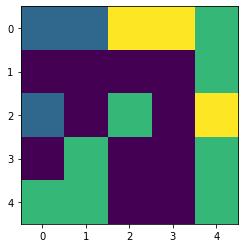

In [3]:
probs, out = torch.max(y_hat, dim=0)
print(probs)
print(out)
plt.imshow(out)

In [4]:
# TODO:
# make dataset
# train

# save params
# torch.save(model.state_dict(), 'SmallSegNet.pt')

# load params
# model = SmallSegNet()
# model.load_state_dict(torch.load('SmallSegNet.pt'))
# model.eval()

## Crossentropy Loss

In [5]:
label =  torch.tensor(
       [[3, 1, 1, 1, 3],
        [3, 3, 0, 3, 3],
        [0, 3, 3, 3, 3],
        [1, 3, 0, 3, 3],
        [0, 3, 3, 3, 3]])

In [6]:
# Crossentropy Loss
criterion = nn.CrossEntropyLoss()

In [7]:
print(y_hat.shape)
y_hat_batch = y_hat[None,:]
print(y_hat_batch.shape)

print(label.shape)
label_batch = label[None,:]
print(label_batch.shape)

torch.Size([4, 5, 5])
torch.Size([1, 4, 5, 5])
torch.Size([5, 5])
torch.Size([1, 5, 5])


In [8]:
loss = criterion(y_hat_batch, label_batch)
loss

tensor(1.3896, grad_fn=<NllLoss2DBackward0>)